In [222]:
import numpy as np
import matplotlib.pyplot as plt
import get_input as inp

from set_simulation import compute_g2
from focal_spot_pattern import create_gaussian_mask

## Trost

In [234]:
def create_slit_pattern_rand_smooth(X, Y, period, angle, dx_source=0):
    # Rotate the coordinates
    angle = np.deg2rad(angle)
    
    X_rot = X * np.cos(angle) + Y * np.sin(angle)

    mask = np.ones_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if (X_rot[i, j] % period) < period / 2:
                mask[i, j] = 1
            else:
                mask[i, j] = -1
    return mask

In [235]:
def rebin_2d(a, bin_factor):
    nrows = (a.shape[0] // bin_factor) * bin_factor
    ncols = (a.shape[1] // bin_factor) * bin_factor
    a_cropped = a[:nrows, :ncols]
    new_shape = (nrows // bin_factor, bin_factor, ncols // bin_factor, bin_factor)
    return a_cropped.reshape(new_shape).sum(axis=(1, 3))

def CCD_detection_binned(intensity, bin_factor, gain=10, QE=0.57, ADC_bits=18):
    """
    Simulate CCD detection by combining binning and photon statistics.
    
    Parameters:
      intensity : 2D array of continuous simulated intensity (e.g., |E|^2).
      bin_factor: Integer number of simulation pixels to combine into one CCD pixel.
      gain      : Gain factor (default: 1).
      QE        : Quantum efficiency (default: 0.57, i.e. 57%).
      ADC_bits  : ADC resolution in bits (default: 10 bits, so max value = 2^10).
      
    Returns:
      detected  : 2D array of simulated CCD counts (integers) after binning and Poisson noise.
    """
    # First, rebin the high-resolution intensity image to the detector pixel scale.
    binned_intensity = rebin_2d(intensity, bin_factor)

    # Now, simulate photon detection using Poisson noise.
    # Here the binned intensity is assumed to represent the mean number of photons per CCD pixel.
    detected = np.random.poisson(binned_intensity) * gain * QE

    # Clip values that exceed the ADC maximum
    max_value = 2 ** ADC_bits
    detected[detected > max_value] = max_value
    
    # Round to nearest integer (simulate ADC digitization)
    detected = np.round(detected).astype(int)
    
    return detected

In [256]:
# initializing variables
setup = inp.Config('inp_files/setup.inp')
setup.padding_factor = int(setup.padding_factor)

In [257]:
dx_source = setup.grid_size/setup.num_pixels
x_det_sim = np.fft.fftshift(np.fft.fftfreq(setup.num_pixels * (1 + setup.padding_factor-1//2), d=dx_source))*setup.wavelength*setup.z_prop
dx_det_sim = x_det_sim[1]-x_det_sim[0]
#print(dx_source)
print(dx_det_sim)
#dx_det_sim = dx_source #(setup.wavelength*setup.z_prop)/(setup.num_pixels*dx_source)
bin_factor = int(round(setup.detector_pixel_size/dx_det_sim))

#auxiliary variables
source_size=dx_source*setup.num_pixels
x_source = np.linspace(-source_size/2, source_size/2, setup.num_pixels, endpoint=False)
y_source = np.linspace(-source_size/2, source_size/2, setup.num_pixels, endpoint=False)
X_source, Y_source = np.meshgrid(x_source, y_source)

print(dx_source)

2.530000000000042e-08
3.3333333333333333e-06


In [258]:
# checking for sampling conditions and Fresnel number
print("Checking for Fresnel number...")
print(f"N_f = {setup.gauss_width**2/(setup.wavelength*setup.z_prop)}\n")

print("Sampling conditions?")
print(bool(2*np.abs(x_source[1]-x_source[0]) >= setup.wavelength*setup.z_prop/source_size))

Checking for Fresnel number...
N_f = 582.3398050065875

Sampling conditions?
True


In [259]:
gaussian_mask1 = create_gaussian_mask(X_source, Y_source, w=setup.gauss_width)
extent = [x_source[0], x_source[-1], y_source[0], y_source[-1]]
grating_mask1 = create_slit_pattern_rand_smooth(X_source, Y_source, setup.stripe_period, angle=73, dx_source=dx_source)
object_mask1 = gaussian_mask1 * grating_mask1

current_object_mask_func = create_slit_pattern_rand_smooth

In [260]:
def fresnel_propagation(E, wavelength, z, dx, padding_factor=1):
    """
    Propagate an input field E using the Fresnel approximation.
    """
    N = E.shape[0]

    pad_width = N * (padding_factor-1)//2

    padded_E = np.pad(E, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant', constant_values=(0+0j,0+0j))
    padded_N = padded_E.shape[0]

    fx = np.fft.fftshift(np.fft.fftfreq(padded_N, d=dx))
    fy = np.fft.fftshift(np.fft.fftfreq(padded_N, d=dx))
    FX, FY = np.meshgrid(fx, fy)

    k = 2 * np.pi / wavelength

    H = np.exp(-1j*k*z)*np.exp(-1j * np.pi * wavelength * z * (FX**2 + FY**2))

    input_spectrum = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(padded_E)))

    output_spectrum = input_spectrum * H

    x_det = fx * wavelength * z
    y_det = fy * wavelength * z

    output_field = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(output_spectrum)))

    return output_spectrum, x_det, y_det

In [268]:
from scipy.signal import correlate2d

In [273]:
def simulate_intensity_images(X_source, Y_source, num_shots, num_modes_per_shot, I0, z_prop, 
                              gauss_width, stripe_period,
                              current_object_mask_func,
                              num_pixels, dx_source, angle, wavelength,
                              bin_factor, gain, QE, ADC_bits, padding_factor, incoherent=False):
    """
    Simulate intensity images from a multi-shot experiment.
    
    Parameters:
      X_source, Y_source: 2D coordinate grids in the source plane (m)
      num_shots: number of shots (different grating masks)
      num_modes_per_shot: number of modes per shot (random phase realizations)
      I0: source intensity (photons per pixel at source)
      z_prop: propagation distance (m)
      gauss_width: diameter (or width) of the Gaussian aperture (m)
      stripe_period: period of the grating (m)
      current_object_mask_func: function to generate a grating mask;
          Called as: current_object_mask_func(X, Y, period, duty_cycle, angle, smoothing_fraction, dx_source)
      num_pixels: simulation grid size (assumed square)
      dx_source: pixel size in the source plane (m)
      angle: angle for the grating mask (radians)
      wavelength: wavelength (m)
      bin_factor: binning factor to convert simulation resolution to detector resolution
      gain, QE, ADC_bits: parameters for CCD_detection_binned.
      
    Returns:
      intensity_images: list of binned intensity images (one per shot)
      field_images: list of the last propagated field from each shot (optional)
    """
    
    intensity_images = []
    field_images = []
    
    # Create the Gaussian mask using the provided gauss_width.
    gaussian_mask = create_gaussian_mask(X_source, Y_source, w=gauss_width)
    
    for shot in range(num_shots):
        # Generate a grating mask (one per shot) using the provided stripe_period.
        grating_mask = current_object_mask_func(X_source, Y_source, stripe_period, angle=angle, dx_source=dx_source)

        # Combine with the Gaussian mask to form the overall object mask.
        current_object_mask = gaussian_mask * grating_mask
        
        # Compute intensity per mode.
        intensity_per_mode = I0 * np.ones((num_pixels, num_pixels)) / num_modes_per_shot
        
        # Initialize accumulator for shot's full-resolution intensity.
        shot_intensity = np.zeros((int(1/2*padding_factor*num_pixels), int(1/2*padding_factor*num_pixels)))

        for mode in range(num_modes_per_shot):
            # Generate a new random phase pattern.
            if not incoherent:
              E_source = np.sqrt(intensity_per_mode)# * np.exp(1j * random_phase)
            else:
              random_phase = np.random.uniform(0, 2*np.pi, (num_pixels, num_pixels))
              E_source = np.sqrt(intensity_per_mode) * np.exp(1j * random_phase)
                
            # Apply the object mask.
            E_after_object = E_source * current_object_mask

            if shot == 0 and mode == 0:  # Plot only for the first shot and mode
                # Plot amplitude and phase *after* the random phase is applied
                intensity_to_plot = np.abs(E_after_object**2) * num_modes_per_shot
                extent = [np.min(X_source), np.max(X_source), np.min(X_source), np.max(X_source)]
                plt.figure()
                plt.imshow(intensity_to_plot, extent=extent, cmap='Greys')
                plt.title(f"Total Source Intensity: {np.sum(intensity_to_plot):.2e} photons per pulse")
                plt.colorbar()
                plt.show()

            # Propagate the field.
            E_det, x_det, y_det = fresnel_propagation(E_after_object, wavelength, z_prop, dx_source, padding_factor=padding_factor)
            I_det = np.abs(E_det)**2
            I_det/=np.max(I_det)
            I_det=I_det[int(1/4*len(I_det)):int(3/4*len(I_det)), int(1/4*len(I_det)):int(3/4*len(I_det))]

            if shot == 0:
              plt.figure()
              extent = [np.min(x_det)/2, np.max(x_det)/2, np.min(y_det)/2, np.max(y_det)/2]
              plt.imshow(I_det, cmap="Greys", extent=extent)
              plt.title("I_det")
              plt.colorbar()
              plt.show()

            shot_intensity += I_det
        
        # Optionally store the last propagated field.
        field_images.append(E_det)

        # Apply CCD detection (including binning, Poisson noise, etc.)
        print(bin_factor)
        shot_intensity_binned = CCD_detection_binned(shot_intensity, bin_factor=bin_factor, gain=gain, QE=QE, ADC_bits=ADC_bits)

        if shot == 0:
            plt.figure()
            plt.imshow(shot_intensity_binned, cmap="Greys")
            plt.title("empty")
            plt.show()

        intensity_images.append(shot_intensity_binned)
        print(f"Completed Shot {shot+1}/{num_shots} - Photons per pixel: {np.sum(shot_intensity_binned)/((num_pixels/bin_factor)**2):.2f}")
    
    return intensity_images, field_images

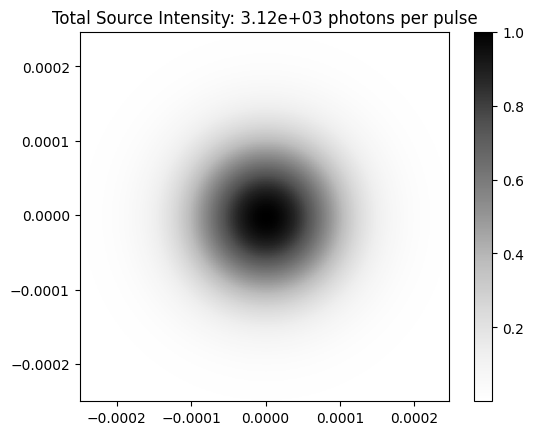

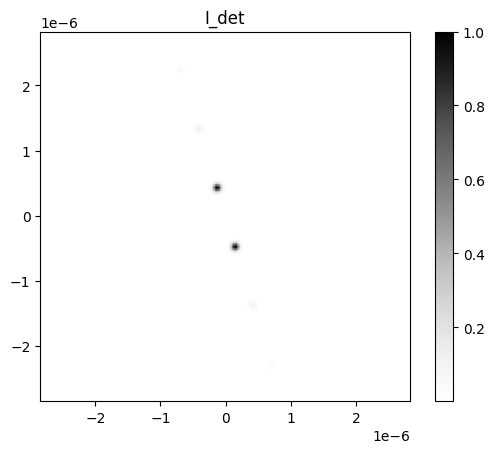

514


C:\Users\joaooo\AppData\Local\Temp\ipykernel_7228\1515331628.py:96: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(shot_intensity_binned, cmap="Greys")
C:\Users\joaooo\AppData\Local\Temp\ipykernel_7228\1515331628.py:96: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(shot_intensity_binned, cmap="Greys")


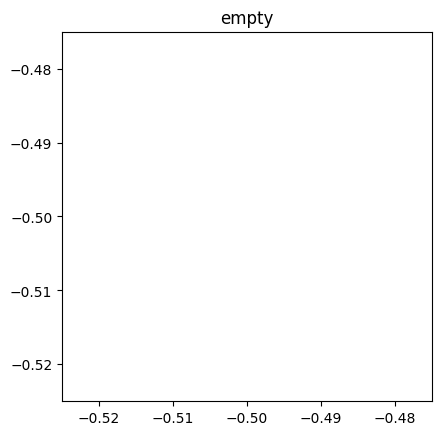

Completed Shot 1/10 - Photons per pixel: 0.00
514
Completed Shot 2/10 - Photons per pixel: 0.00
514
Completed Shot 3/10 - Photons per pixel: 0.00
514
Completed Shot 4/10 - Photons per pixel: 0.00
514
Completed Shot 5/10 - Photons per pixel: 0.00
514
Completed Shot 6/10 - Photons per pixel: 0.00
514
Completed Shot 7/10 - Photons per pixel: 0.00
514
Completed Shot 8/10 - Photons per pixel: 0.00
514
Completed Shot 9/10 - Photons per pixel: 0.00
514
Completed Shot 10/10 - Photons per pixel: 0.00


In [274]:
intensity_images, field_images = simulate_intensity_images(X_source, Y_source, setup.num_shots, setup.num_modes_per_shot, setup.I0, setup.z_prop, 
                                                          setup.gauss_width, setup.stripe_period,
                                                          current_object_mask_func,
                                                          setup.num_pixels, dx_source, setup.angle, setup.wavelength,
                                                          bin_factor, setup.gain, setup.QE, setup.ADC_bits, setup.padding_factor)

## Custom

In [354]:
# initializing variables
setup = inp.Config('inp_files/setup_2.inp')
setup.padding_factor = int(setup.padding_factor)

In [355]:
dx_source = setup.grid_size/setup.num_pixels
x_det_sim = np.fft.fftshift(np.fft.fftfreq(setup.num_pixels * (setup.padding_factor-1)//2, d=dx_source))*setup.wavelength*setup.z_prop
dx_det_sim = x_det_sim[1]-x_det_sim[0]
#print(dx_source)
print(x_det_sim)
#dx_det_sim = dx_source #(setup.wavelength*setup.z_prop)/(setup.num_pixels*dx_source)
bin_factor = int(round(setup.detector_pixel_size/dx_det_sim))

#auxiliary variables
source_size=dx_source*setup.num_pixels
x_source = np.linspace(-source_size/2, source_size/2, setup.num_pixels, endpoint=False)
y_source = np.linspace(-source_size/2, source_size/2, setup.num_pixels, endpoint=False)
X_source, Y_source = np.meshgrid(x_source, y_source)

print(dx_source)

[-3.4375e-04 -3.4100e-04 -3.3825e-04 -3.3550e-04 -3.3275e-04 -3.3000e-04
 -3.2725e-04 -3.2450e-04 -3.2175e-04 -3.1900e-04 -3.1625e-04 -3.1350e-04
 -3.1075e-04 -3.0800e-04 -3.0525e-04 -3.0250e-04 -2.9975e-04 -2.9700e-04
 -2.9425e-04 -2.9150e-04 -2.8875e-04 -2.8600e-04 -2.8325e-04 -2.8050e-04
 -2.7775e-04 -2.7500e-04 -2.7225e-04 -2.6950e-04 -2.6675e-04 -2.6400e-04
 -2.6125e-04 -2.5850e-04 -2.5575e-04 -2.5300e-04 -2.5025e-04 -2.4750e-04
 -2.4475e-04 -2.4200e-04 -2.3925e-04 -2.3650e-04 -2.3375e-04 -2.3100e-04
 -2.2825e-04 -2.2550e-04 -2.2275e-04 -2.2000e-04 -2.1725e-04 -2.1450e-04
 -2.1175e-04 -2.0900e-04 -2.0625e-04 -2.0350e-04 -2.0075e-04 -1.9800e-04
 -1.9525e-04 -1.9250e-04 -1.8975e-04 -1.8700e-04 -1.8425e-04 -1.8150e-04
 -1.7875e-04 -1.7600e-04 -1.7325e-04 -1.7050e-04 -1.6775e-04 -1.6500e-04
 -1.6225e-04 -1.5950e-04 -1.5675e-04 -1.5400e-04 -1.5125e-04 -1.4850e-04
 -1.4575e-04 -1.4300e-04 -1.4025e-04 -1.3750e-04 -1.3475e-04 -1.3200e-04
 -1.2925e-04 -1.2650e-04 -1.2375e-04 -1.2100e-04 -1

In [356]:
# checking for sampling conditions and Fresnel number
print("Checking for Fresnel number...")
print(f"N_f = {setup.gauss_width**2/(setup.wavelength*setup.z_prop)}\n")

print("Sampling conditions?")
print(bool(2*np.abs(x_source[1]-x_source[0]) >= setup.wavelength*setup.z_prop/source_size))

Checking for Fresnel number...
N_f = 2.272727272727273

Sampling conditions?
False


In [357]:
gaussian_mask1 = create_gaussian_mask(X_source, Y_source, w=setup.gauss_width)
extent = [x_source[0], x_source[-1], y_source[0], y_source[-1]]
grating_mask1 = create_slit_pattern_rand_smooth(X_source, Y_source, setup.stripe_period, angle=73, dx_source=dx_source)
object_mask1 = gaussian_mask1 * grating_mask1

current_object_mask_func = create_slit_pattern_rand_smooth

In [358]:
def fresnel_propagation(E, wavelength, z, dx, padding_factor=1):
    """
    Propagate an input field E using the Fresnel approximation.
    """
    N = E.shape[0]

    pad_width = N * (padding_factor-1)//2

    padded_E = np.pad(E, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant', constant_values=(0+0j,0+0j))
    padded_N = padded_E.shape[0]

    fx = np.fft.fftshift(np.fft.fftfreq(padded_N, d=dx))
    fy = np.fft.fftshift(np.fft.fftfreq(padded_N, d=dx))
    FX, FY = np.meshgrid(fx, fy)

    k = 2 * np.pi / wavelength

    H = np.exp(-1j*k*z)*np.exp(-1j * np.pi * wavelength * z * (FX**2 + FY**2))

    input_spectrum = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(padded_E)))

    output_spectrum = input_spectrum * H

    x_det = fx * wavelength * z
    y_det = fy * wavelength * z

    output_field = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(output_spectrum)))

    return output_spectrum, x_det, y_det

In [359]:
def simulate_intensity_images(X_source, Y_source, num_shots, num_modes_per_shot, I0, z_prop, 
                              gauss_width, stripe_period,
                              current_object_mask_func,
                              num_pixels, dx_source, angle, wavelength,
                              bin_factor, gain, QE, ADC_bits, padding_factor, incoherent=False):
    """
    Simulate intensity images from a multi-shot experiment.
    
    Parameters:
      X_source, Y_source: 2D coordinate grids in the source plane (m)
      num_shots: number of shots (different grating masks)
      num_modes_per_shot: number of modes per shot (random phase realizations)
      I0: source intensity (photons per pixel at source)
      z_prop: propagation distance (m)
      gauss_width: diameter (or width) of the Gaussian aperture (m)
      stripe_period: period of the grating (m)
      current_object_mask_func: function to generate a grating mask;
          Called as: current_object_mask_func(X, Y, period, duty_cycle, angle, smoothing_fraction, dx_source)
      num_pixels: simulation grid size (assumed square)
      dx_source: pixel size in the source plane (m)
      angle: angle for the grating mask (radians)
      wavelength: wavelength (m)
      bin_factor: binning factor to convert simulation resolution to detector resolution
      gain, QE, ADC_bits: parameters for CCD_detection_binned.
      
    Returns:
      intensity_images: list of binned intensity images (one per shot)
      field_images: list of the last propagated field from each shot (optional)
    """
    
    intensity_images = []
    field_images = []
    
    # Create the Gaussian mask using the provided gauss_width.
    gaussian_mask = create_gaussian_mask(X_source, Y_source, w=gauss_width)
    
    for shot in range(num_shots):
        # Generate a grating mask (one per shot) using the provided stripe_period.
        grating_mask = current_object_mask_func(X_source, Y_source, stripe_period, angle=angle, dx_source=dx_source)

        # Combine with the Gaussian mask to form the overall object mask.
        current_object_mask = gaussian_mask * grating_mask
        
        # Compute intensity per mode.
        intensity_per_mode = I0 * np.ones((num_pixels, num_pixels)) / num_modes_per_shot
        
        # Initialize accumulator for shot's full-resolution intensity.
        shot_intensity = np.zeros((int(1/2*padding_factor*num_pixels), int(1/2*padding_factor*num_pixels)))

        for mode in range(num_modes_per_shot):
            # Generate a new random phase pattern.
            if not incoherent:
              E_source = np.sqrt(intensity_per_mode)# * np.exp(1j * random_phase)
            else:
              random_phase = np.random.uniform(0, 2*np.pi, (num_pixels, num_pixels))
              E_source = np.sqrt(intensity_per_mode) * np.exp(1j * random_phase)
                
            # Apply the object mask.
            E_after_object = E_source * current_object_mask

            if shot == 0 and mode == 0:  # Plot only for the first shot and mode
                # Plot amplitude and phase *after* the random phase is applied
                intensity_to_plot = np.abs(E_after_object**2) * num_modes_per_shot
                extent = [np.min(X_source), np.max(X_source), np.min(X_source), np.max(X_source)]
                plt.figure(figsize=(8, 6))
                plt.imshow(intensity_to_plot, extent=extent, cmap='Greys')
                plt.title(f"Total Source Intensity: {np.sum(intensity_to_plot):.2e} photons per pulse")
                plt.colorbar()
                plt.show()

            # Propagate the field.
            print(np.sum(np.abs(E_after_object)**2))
            E_det, x_det, y_det = fresnel_propagation(E_after_object, wavelength, z_prop, dx_source, padding_factor=padding_factor)
            print(x_det, y_det)
            print(np.sum(np.abs(E_det)**2))
            I_det = np.abs(E_det)**2
            I_det/=np.max(I_det)
            I_det=I_det[int(1/4*len(I_det)):int(3/4*len(I_det)), int(1/4*len(I_det)):int(3/4*len(I_det))]

            if shot == 0:
              plt.figure()
              extent = [np.min(x_det)/2, np.max(x_det)/2, np.min(y_det)/2, np.max(y_det)/2]
              plt.imshow(I_det, cmap="Greys", extent=extent)
              plt.title("I_det")
              plt.colorbar()
              plt.show()

            shot_intensity += I_det
        
        # Optionally store the last propagated field.
        field_images.append(E_det)

        # Apply CCD detection (including binning, Poisson noise, etc.)
        shot_intensity_binned = CCD_detection_binned(shot_intensity, bin_factor=bin_factor, gain=gain, QE=QE, ADC_bits=ADC_bits)

        if shot == 0:
            plt.figure()
            plt.imshow(shot_intensity_binned, cmap="Greys")
            plt.show()

        intensity_images.append(shot_intensity_binned)
        print(f"Completed Shot {shot+1}/{num_shots} - Photons per pixel: {np.sum(shot_intensity_binned)/((num_pixels/bin_factor)**2):.2f}")
    
    return intensity_images, field_images

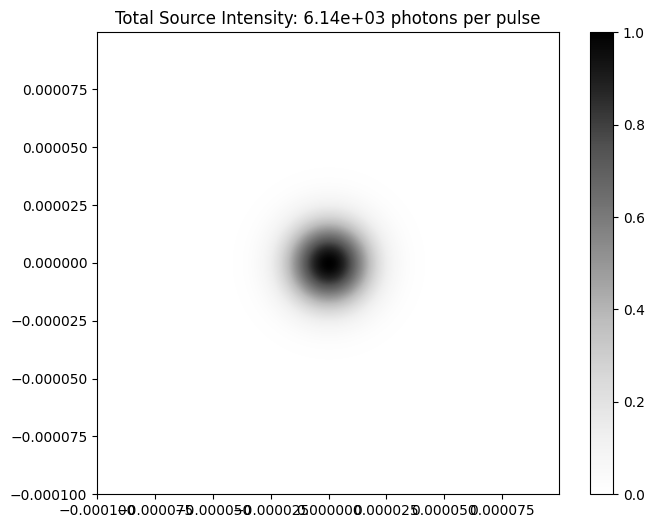

6135.923151542547
[-3.437500e-04 -3.430625e-04 -3.423750e-04 -3.416875e-04 -3.410000e-04
 -3.403125e-04 -3.396250e-04 -3.389375e-04 -3.382500e-04 -3.375625e-04
 -3.368750e-04 -3.361875e-04 -3.355000e-04 -3.348125e-04 -3.341250e-04
 -3.334375e-04 -3.327500e-04 -3.320625e-04 -3.313750e-04 -3.306875e-04
 -3.300000e-04 -3.293125e-04 -3.286250e-04 -3.279375e-04 -3.272500e-04
 -3.265625e-04 -3.258750e-04 -3.251875e-04 -3.245000e-04 -3.238125e-04
 -3.231250e-04 -3.224375e-04 -3.217500e-04 -3.210625e-04 -3.203750e-04
 -3.196875e-04 -3.190000e-04 -3.183125e-04 -3.176250e-04 -3.169375e-04
 -3.162500e-04 -3.155625e-04 -3.148750e-04 -3.141875e-04 -3.135000e-04
 -3.128125e-04 -3.121250e-04 -3.114375e-04 -3.107500e-04 -3.100625e-04
 -3.093750e-04 -3.086875e-04 -3.080000e-04 -3.073125e-04 -3.066250e-04
 -3.059375e-04 -3.052500e-04 -3.045625e-04 -3.038750e-04 -3.031875e-04
 -3.025000e-04 -3.018125e-04 -3.011250e-04 -3.004375e-04 -2.997500e-04
 -2.990625e-04 -2.983750e-04 -2.976875e-04 -2.970000e-04 -2

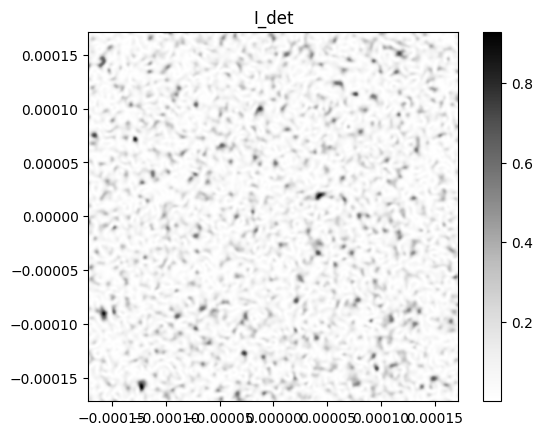

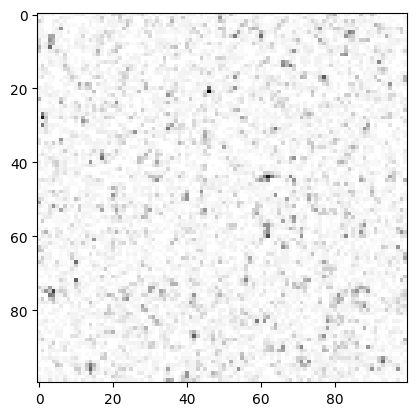

Completed Shot 1/100 - Photons per pixel: 1.89
6135.923151542547
[-3.437500e-04 -3.430625e-04 -3.423750e-04 -3.416875e-04 -3.410000e-04
 -3.403125e-04 -3.396250e-04 -3.389375e-04 -3.382500e-04 -3.375625e-04
 -3.368750e-04 -3.361875e-04 -3.355000e-04 -3.348125e-04 -3.341250e-04
 -3.334375e-04 -3.327500e-04 -3.320625e-04 -3.313750e-04 -3.306875e-04
 -3.300000e-04 -3.293125e-04 -3.286250e-04 -3.279375e-04 -3.272500e-04
 -3.265625e-04 -3.258750e-04 -3.251875e-04 -3.245000e-04 -3.238125e-04
 -3.231250e-04 -3.224375e-04 -3.217500e-04 -3.210625e-04 -3.203750e-04
 -3.196875e-04 -3.190000e-04 -3.183125e-04 -3.176250e-04 -3.169375e-04
 -3.162500e-04 -3.155625e-04 -3.148750e-04 -3.141875e-04 -3.135000e-04
 -3.128125e-04 -3.121250e-04 -3.114375e-04 -3.107500e-04 -3.100625e-04
 -3.093750e-04 -3.086875e-04 -3.080000e-04 -3.073125e-04 -3.066250e-04
 -3.059375e-04 -3.052500e-04 -3.045625e-04 -3.038750e-04 -3.031875e-04
 -3.025000e-04 -3.018125e-04 -3.011250e-04 -3.004375e-04 -2.997500e-04
 -2.990625e-

In [360]:
intensity_images, field_images = simulate_intensity_images(X_source, Y_source, setup.num_shots, setup.num_modes_per_shot, setup.I0, setup.z_prop, 
                                                          setup.gauss_width, setup.stripe_period,
                                                          current_object_mask_func,
                                                          setup.num_pixels, dx_source, setup.angle, setup.wavelength,
                                                          bin_factor, setup.gain, setup.QE, setup.ADC_bits, setup.padding_factor, incoherent=True)

In [361]:
from scipy.signal import fftconvolve

def compute_g2(intensity_images):
    """
    Compute the ensemble-averaged intensity, autocorrelation (g² proxy),
    and vertical lineout from a list of intensity images.
    
    Returns:
      avg_intensity: ensemble-averaged intensity image
      autocorr_avg: averaged autocorrelation of intensity fluctuations
      vertical_sum: vertical lineout (summed along rows) of autocorr_avg
      I_per_pix: average number of photons per pixel (scalar)
    """
    num_shots = len(intensity_images)
    avg_intensity = np.mean(intensity_images, axis=0)
    deltaI_images = [img - avg_intensity for img in intensity_images]
    N_bin = avg_intensity.shape[0]
    autocorr_sum = np.zeros((N_bin, N_bin))
    for I in deltaI_images:
        autocorr = fftconvolve(I, I[::-1, ::-1], mode='same')
        #autocorr /= np.mean(I)**2
        autocorr_sum += autocorr
    autocorr_avg = autocorr_sum / num_shots
    I_per_pix = np.mean(avg_intensity)
    vertical_sum = np.sum(autocorr_avg, axis=0)
    return avg_intensity, autocorr_avg, vertical_sum, I_per_pix

In [362]:
avg_intensity, autocorr_avg, vertical_sum, I_per_pix = compute_g2(intensity_images)

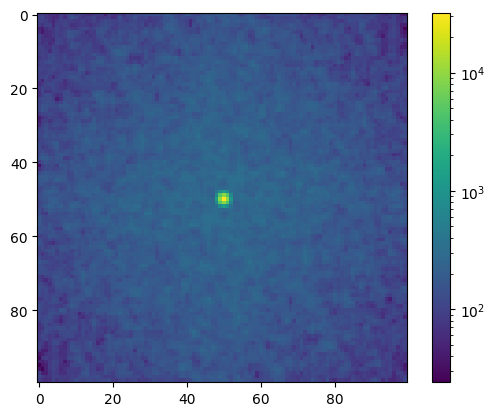

In [363]:
plt.figure()
plt.imshow(autocorr_avg-1, norm=mcolors.LogNorm())
plt.colorbar()
plt.show()